In [2]:
# !pip install --upgrade seaborn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
%matplotlib inline

# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서  음수 부호 설정
mpl.rc('axes', unicode_minus=False)

path='../data/Paris/listings.csv'
raw = pd.read_csv(path)
df = raw.copy()

df = df[['id', 'host_id','host_is_superhost',
        'host_total_listings_count','neighbourhood_cleansed','room_type','accommodates','bathrooms','bedrooms',
        'beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'reviews_per_month','listing_url','property_type','number_of_reviews_ltm','has_availability','last_review']]

df = df.rename(columns= {
    'id': '숙소_id',
    'host_id': '호스트_id',
    'host_is_superhost': '슈퍼호스트',
    'host_total_listings_count': '숙소_수',
    'neighbourhood_cleansed': '숙소_지역',
    'room_type': '숙소_유형',
    'accommodates': '수용_인원수',
    'bathrooms': '욕실수',
    'bedrooms': '침실수',
    'beds': '침대수',
    'amenities': '편의시설',
    'price': '숙소_가격',
    'minimum_nights': '최소_숙박일',
    'maximum_nights': '최대_숙박일',
    'number_of_reviews': '리뷰수',
    'number_of_reviews_l30d': '30일_리뷰수',
    'review_scores_rating': '리뷰점수',
    'review_scores_accuracy': '숙소_정확성_리뷰점수',
    'review_scores_cleanliness': '숙소_청결도_리뷰점수',
    'review_scores_checkin': '숙소_체크인_리뷰점수',
    'review_scores_communication': '숙소_소통_리뷰점수',
    'review_scores_location': '숙소_위치_리뷰점수',
    'review_scores_value': '숙소_가격_리뷰점수',
    'reviews_per_month': '평균_리뷰수',
    'listing_url':'url',
    'property_type':'숙소_특징',
    'number_of_reviews_ltm':'12개월_리뷰수',
    'has_availability':'예약가능여부',
    'last_review':'마지막_리뷰'
})


# 슈퍼호스트, 리뷰수 결측치 제거
print(f"처음 df : {len(df)}")
df = df[~df['슈퍼호스트'].isnull()]
print(f"슈퍼호스트 제거 : {len(df)}")
df = df[df['리뷰수']>2]
print(f"리뷰수 제거 : {len(df)}")

# 숙소가격 null값 제거
df= df[~df['숙소_가격'].isnull()]

#가격 앞 통화기호 제거
df['숙소_가격'] = df['숙소_가격'].replace('[\$,]', '', regex=True).astype(float)

# 유형 제거 
df = df[(df['숙소_유형']=='Entire home/apt') | (df['숙소_유형']=='Private room')]
print(f"숙소_유형 제거 : {len(df)}")

# 12개월 리뷰수 0 개 제거
df = df[df['12개월_리뷰수']!=0]
print(f"12개월_리뷰수 0개 제거 : {len(df)}")

# 욕실수, 침실수, 침대수 null값 제거
df = df.dropna(subset=['욕실수', '침실수', '침대수'])
print(f"욕실수, 침실수, 침대수 제거 후 : {len(df)}")

# 리뷰  null값 제거
df = df.dropna(subset=['숙소_정확성_리뷰점수','숙소_청결도_리뷰점수','숙소_체크인_리뷰점수','숙소_소통_리뷰점수','숙소_위치_리뷰점수','숙소_가격_리뷰점수'])
print(f"리뷰 결측치 제거 후 : {len(df)}")

# 예약 가능여부 f 버리기
df = df.dropna(subset='예약가능여부')
print(f"예약가능여부 : {len(df)}")

처음 df : 84397
슈퍼호스트 제거 : 84306
리뷰수 제거 : 47841
숙소_유형 제거 : 34280
12개월_리뷰수 0개 제거 : 31052
욕실수, 침실수, 침대수 제거 후 : 30997
리뷰 결측치 제거 후 : 30997
예약가능여부 : 30990


이상치 처리 

In [4]:
#수용 인원수, 숙소_가격 이상치 제거 

import pandas as pd

# 이상치를 제거하는 함수 정의
def remove_outliers(df, column, type):
    condition = (df['숙소_유형'] == type)
    
    if column != '숙소_가격':
        Q1 = df[column][condition].quantile(0.25)
        Q3 = df[column][condition].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR

        outlier = df[column] > upper_bound
        upper_outlier = df[condition & outlier]
    else:
        Q1 = df[column][condition].quantile(0.25)
        Q3 = df[column][condition].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 3 * IQR

        outlier = df[column] > upper_bound
        upper_outlier = df[condition & outlier]

    upper_outlier_indices = upper_outlier.index
    df.drop(index=upper_outlier_indices, inplace=True)

# 숙소 가격 및 수용 인원수의 이상치 제거
remove_outliers(df, '수용_인원수', 'Entire home/apt')
remove_outliers(df, '수용_인원수', 'Private room')
remove_outliers(df, '숙소_가격', 'Entire home/apt')
remove_outliers(df, '숙소_가격', 'Private room')

이상치 제거 후 : 28842

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28842 entries, 1 to 83158
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   숙소_id        28842 non-null  int64  
 1   호스트_id       28842 non-null  int64  
 2   슈퍼호스트        28842 non-null  object 
 3   숙소_수         28842 non-null  float64
 4   숙소_지역        28842 non-null  object 
 5   숙소_유형        28842 non-null  object 
 6   수용_인원수       28842 non-null  int64  
 7   욕실수          28842 non-null  float64
 8   침실수          28842 non-null  float64
 9   침대수          28842 non-null  float64
 10  편의시설         28842 non-null  object 
 11  숙소_가격        28842 non-null  float64
 12  최소_숙박일       28842 non-null  int64  
 13  최대_숙박일       28842 non-null  int64  
 14  리뷰수          28842 non-null  int64  
 15  30일_리뷰수      28842 non-null  int64  
 16  리뷰점수         28842 non-null  float64
 17  숙소_정확성_리뷰점수  28842 non-null  float64
 18  숙소_청결도_리뷰점수  28842 non-null  float64
 19  숙소_체크인_리뷰

In [6]:
df.columns

Index(['숙소_id', '호스트_id', '슈퍼호스트', '숙소_수', '숙소_지역', '숙소_유형', '수용_인원수', '욕실수',
       '침실수', '침대수', '편의시설', '숙소_가격', '최소_숙박일', '최대_숙박일', '리뷰수', '30일_리뷰수',
       '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수',
       '숙소_위치_리뷰점수', '숙소_가격_리뷰점수', '평균_리뷰수', 'url', '숙소_특징', '12개월_리뷰수',
       '예약가능여부', '마지막_리뷰'],
      dtype='object')

PCA 전 상관계수 확인

In [7]:
# 상관계수에 불필요한 컬럼들 제거
df_clean = df.drop(columns=['숙소_id', '호스트_id', 'url', '편의시설','예약가능여부','마지막_리뷰',
                            '슈퍼호스트','숙소_지역', '숙소_유형','숙소_특징'])


In [8]:
df_clean.head(3)

,숙소_수,수용_인원수,욕실수,침실수,침대수,숙소_가격,최소_숙박일,최대_숙박일,리뷰수,30일_리뷰수,리뷰점수,숙소_정확성_리뷰점수,숙소_청결도_리뷰점수,숙소_체크인_리뷰점수,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,12개월_리뷰수
1,1.0,2,1.0,0.0,1.0,140.0,3,365,106,0,4.68,4.72,4.59,4.87,4.89,4.95,4.74,0.69,14
2,3.0,2,1.0,0.0,1.0,107.0,1,1125,393,5,4.60,4.63,4.57,4.81,4.84,4.96,4.58,2.19,61
3,3.0,4,1.0,1.0,1.0,200.0,2,120,78,0,4.56,4.74,4.37,4.82,4.79,4.65,4.48,0.51,1


In [9]:
df_clean.corr()

,숙소_수,수용_인원수,욕실수,침실수,침대수,숙소_가격,최소_숙박일,최대_숙박일,리뷰수,30일_리뷰수,리뷰점수,숙소_정확성_리뷰점수,숙소_청결도_리뷰점수,숙소_체크인_리뷰점수,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,12개월_리뷰수
숙소_수,1.000000,0.066526,0.051831,0.009017,0.047421,0.042374,0.050510,0.159567,-0.035092,-0.000192,-0.175309,-0.157913,-0.112502,-0.180465,-0.208962,-0.045801,-0.182290,-0.018684,-0.030518
수용_인원수,0.066526,1.000000,0.406176,0.581419,0.759323,0.528446,-0.060296,0.064898,0.000975,0.008531,-0.028180,-0.042851,-0.022789,-0.051055,-0.051395,-0.013256,-0.023814,0.019169,0.015537
욕실수,0.051831,0.406176,1.000000,0.407956,0.379727,0.396770,-0.023264,0.033930,-0.008677,-0.005593,0.057814,0.032596,0.063067,0.012071,0.015097,0.043733,0.060439,-0.009013,-0.005250
침실수,0.009017,0.581419,0.407956,1.000000,0.549814,0.470422,-0.055255,-0.010765,-0.038728,-0.067287,0.087634,0.061333,0.055036,0.035825,0.043888,0.029649,0.090769,-0.073025,-0.053214
침대수,0.047421,0.759323,0.379727,0.549814,1.000000,0.447148,-0.027187,0.053781,0.029498,-0.021007,-0.009136,-0.025444,-0.004418,-0.024969,-0.031697,0.005738,0.000889,-0.026545,0.011307
숙소_가격,0.042374,0.528446,0.396770,0.470422,0.447148,1.000000,-0.077408,0.053556,-0.026516,-0.113856,0.160296,0.123364,0.175022,0.066368,0.068428,0.198400,0.133332,-0.096422,-0.055916
최소_숙박일,0.050510,-0.060296,-0.023264,-0.055255,-0.027187,-0.077408,1.000000,0.045376,-0.038492,-0.082155,-0.020572,-0.014530,-0.031901,-0.010478,-0.041637,0.016289,-0.038001,-0.132053,-0.109052
최대_숙박일,0.159567,0.064898,0.033930,-0.010765,0.053781,0.053556,0.045376,1.000000,0.101850,0.021298,-0.108739,-0.087410,-0.069278,-0.098207,-0.114745,-0.026652,-0.103687,0.013080,0.048221
리뷰수,-0.035092,0.000975,-0.008677,-0.038728,0.029498,-0.026516,-0.038492,0.101850,1.000000,0.343631,-0.011984,0.028399,0.047836,0.045038,0.024854,0.037504,0.039994,0.453232,0.673169
30일_리뷰수,-0.000192,0.008531,-0.005593,-0.067287,-0.021007,-0.113856,-0.082155,0.021298,0.343631,1.000000,-0.001109,-0.006457,0.055801,0.017415,0.014905,0.019849,0.017544,0.705505,0.584167


In [10]:
df_clean_corr = df_clean.corr()

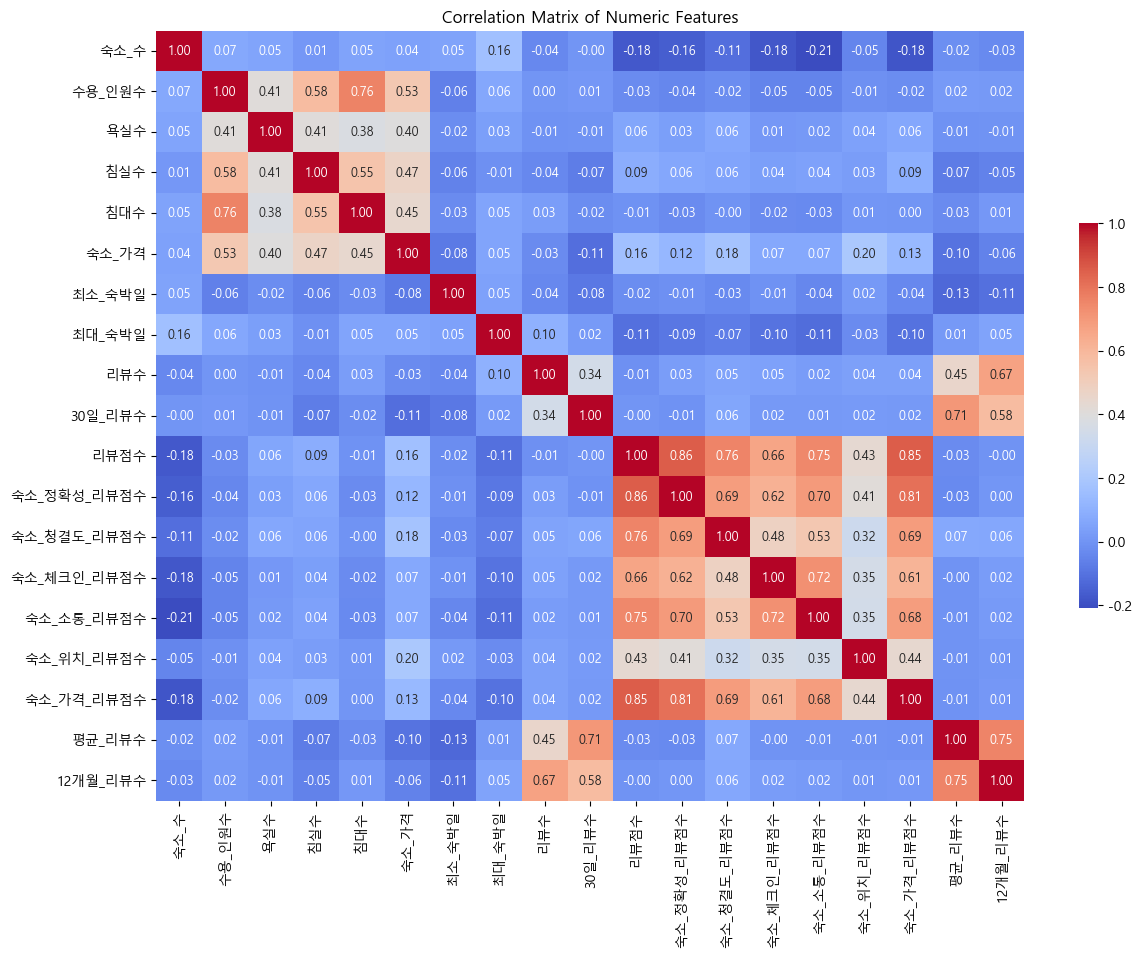

In [11]:
# 히트맵 
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 히트맵 그리기
plt.figure(figsize=(14, 10))
sns.heatmap(df_clean_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'shrink': 0.5}, annot_kws={'size': 9})
plt.title('Correlation Matrix of Numeric Features')

plt.show()

좋은 숙소 기준 : 게스트 선호
 - 평점 4.9이상
 - 2년간 리뷰수 5개 이상
 - 예약_취소율 1%미만 -> 슈퍼호스트 여부로 대체 가능

In [12]:
df[(df['리뷰점수'] >= 4.9) & (df['리뷰수'] >= 5) & (df['슈퍼호스트'] == 't')]

,숙소_id,호스트_id,슈퍼호스트,숙소_수,숙소_지역,숙소_유형,수용_인원수,욕실수,침실수,침대수,...,숙소_체크인_리뷰점수,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,url,숙소_특징,12개월_리뷰수,예약가능여부,마지막_리뷰
27,9952,33534,t,1.0,Popincourt,Entire home/apt,2,1.0,1.0,1.0,...,4.98,4.86,4.88,4.90,0.37,https://www.airbnb.com/rooms/9952,Entire rental unit,7,t,2023-09-24
45,195564,938912,t,1.0,Gobelins,Entire home/apt,3,1.0,1.0,2.0,...,4.98,5.00,4.83,4.83,0.47,https://www.airbnb.com/rooms/195564,Entire rental unit,5,t,2023-07-07
48,54377,247562,t,3.0,Buttes-Montmartre,Entire home/apt,4,1.0,1.0,1.0,...,4.98,5.00,4.53,4.88,1.30,https://www.airbnb.com/rooms/54377,Entire rental unit,35,t,2024-01-03
53,55348,261355,t,7.0,Hôtel-de-Ville,Entire home/apt,2,1.0,0.0,1.0,...,4.91,4.94,4.98,4.85,0.93,https://www.airbnb.com/rooms/55348,Entire rental unit,25,t,2024-02-29
77,215763,1113807,t,2.0,Entrepôt,Entire home/apt,2,1.0,1.0,1.0,...,4.91,4.94,4.96,4.87,1.04,https://www.airbnb.com/rooms/215763,Entire rental unit,24,t,2024-03-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77625,1077678541993753725,33676510,t,2.0,Entrepôt,Entire home/apt,2,1.0,1.0,2.0,...,5.00,5.00,4.80,5.00,4.41,https://www.airbnb.com/rooms/1077678541993753725,Entire rental unit,5,t,2024-03-10
78171,1079775036826711802,14267686,t,1.0,Observatoire,Private room,2,1.5,1.0,1.0,...,5.00,4.92,4.92,4.83,8.78,https://www.airbnb.com/rooms/1079775036826711802,Private room in rental unit,12,t,2024-03-16
78192,1080250485815449505,242694272,t,3.0,Buttes-Montmartre,Entire home/apt,4,1.5,2.0,2.0,...,5.00,5.00,5.00,5.00,6.00,https://www.airbnb.com/rooms/1080250485815449505,Entire rental unit,7,t,2024-03-16
78307,1080943945230018972,33985517,t,46.0,Opéra,Entire home/apt,6,3.5,3.0,3.0,...,5.00,5.00,5.00,4.80,3.41,https://www.airbnb.com/rooms/1080943945230018972,Entire rental unit,5,t,2024-03-12


해당 조건에 들어가는 데이터 개수 : 4716개

In [13]:
df_guest_prefer= df[(df['리뷰점수'] >= 4.9) & (df['리뷰수'] >= 5) & (df['슈퍼호스트'] == 't')]
df_guest_prefer.head()

,숙소_id,호스트_id,슈퍼호스트,숙소_수,숙소_지역,숙소_유형,수용_인원수,욕실수,침실수,침대수,...,숙소_체크인_리뷰점수,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,url,숙소_특징,12개월_리뷰수,예약가능여부,마지막_리뷰
27,9952,33534,t,1.0,Popincourt,Entire home/apt,2,1.0,1.0,1.0,...,4.98,4.86,4.88,4.90,0.37,https://www.airbnb.com/rooms/9952,Entire rental unit,7,t,2023-09-24
45,195564,938912,t,1.0,Gobelins,Entire home/apt,3,1.0,1.0,2.0,...,4.98,5.00,4.83,4.83,0.47,https://www.airbnb.com/rooms/195564,Entire rental unit,5,t,2023-07-07
48,54377,247562,t,3.0,Buttes-Montmartre,Entire home/apt,4,1.0,1.0,1.0,...,4.98,5.00,4.53,4.88,1.30,https://www.airbnb.com/rooms/54377,Entire rental unit,35,t,2024-01-03
53,55348,261355,t,7.0,Hôtel-de-Ville,Entire home/apt,2,1.0,0.0,1.0,...,4.91,4.94,4.98,4.85,0.93,https://www.airbnb.com/rooms/55348,Entire rental unit,25,t,2024-02-29
77,215763,1113807,t,2.0,Entrepôt,Entire home/apt,2,1.0,1.0,1.0,...,4.91,4.94,4.96,4.87,1.04,https://www.airbnb.com/rooms/215763,Entire rental unit,24,t,2024-03-12


불필요한 컬럼 삭제

In [14]:
df_guest_prefer.drop(columns=['숙소_id','호스트_id','url','슈퍼호스트','편의시설','예약가능여부','마지막_리뷰'],axis=1, inplace=True)
df_guest_prefer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4322 entries, 27 to 78309
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   숙소_수         4322 non-null   float64
 1   숙소_지역        4322 non-null   object 
 2   숙소_유형        4322 non-null   object 
 3   수용_인원수       4322 non-null   int64  
 4   욕실수          4322 non-null   float64
 5   침실수          4322 non-null   float64
 6   침대수          4322 non-null   float64
 7   숙소_가격        4322 non-null   float64
 8   최소_숙박일       4322 non-null   int64  
 9   최대_숙박일       4322 non-null   int64  
 10  리뷰수          4322 non-null   int64  
 11  30일_리뷰수      4322 non-null   int64  
 12  리뷰점수         4322 non-null   float64
 13  숙소_정확성_리뷰점수  4322 non-null   float64
 14  숙소_청결도_리뷰점수  4322 non-null   float64
 15  숙소_체크인_리뷰점수  4322 non-null   float64
 16  숙소_소통_리뷰점수   4322 non-null   float64
 17  숙소_위치_리뷰점수   4322 non-null   float64
 18  숙소_가격_리뷰점수   4322 non-null   float64
 19  평균_리뷰수   

C:\Users\rladn\AppData\Local\Temp\ipykernel_1576\2688296093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_guest_prefer.drop(columns=['숙소_id','호스트_id','url','슈퍼호스트','편의시설','예약가능여부','마지막_리뷰'],axis=1, inplace=True)


## 게스트 선호에 대한 EDA

숙소_지역, 숙소_유형, 숙소_특징의 분포 시각화

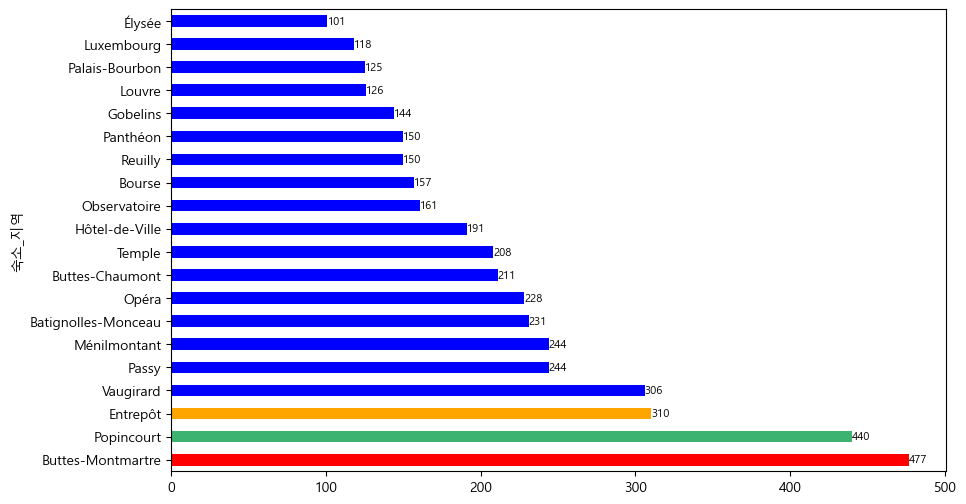

In [15]:
import matplotlib.pyplot as plt

# 숙소_지역별 count 계산
region_count = df_guest_prefer['숙소_지역'].value_counts()

# top 3 지역 추출
top3_regions = region_count.nlargest(3)

# 그래프 그리기
colors = ['r', 'mediumseagreen', 'orange', 'lightblue']  # top 3 지역에 대한 색깔 지정
plt.figure(figsize=(10,6))
region_count.plot(kind='barh', color=[colors[i] if region_count.index[i] in top3_regions.index else 'b' for i in range(len(region_count))])
for i, v in enumerate(region_count):
    plt.text(v, i, str(v), ha='left', va='center', fontsize=8)
plt.show()


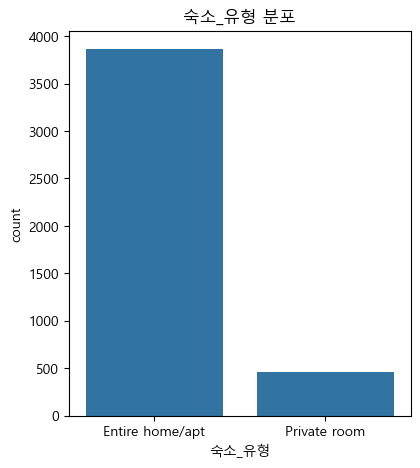

In [16]:
# 숙소_유형 분포 시각화

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
sns.countplot(data=df_guest_prefer, x='숙소_유형')
plt.title('숙소_유형 분포')
plt.show()

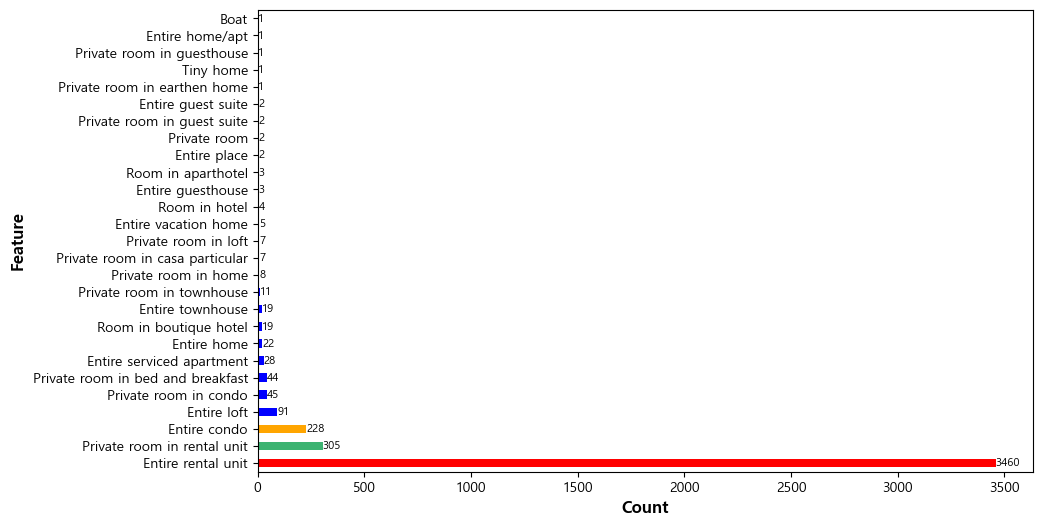

In [17]:
import matplotlib.pyplot as plt

# 숙소_특징별 count 계산
char_count = df_guest_prefer['숙소_특징'].value_counts()

# top 3 특징 추출
top3_char = char_count.nlargest(3)

# 그래프 그리기
colors = ['r', 'mediumseagreen', 'orange', 'lightblue']  # top 3 특징에 대한 색깔 지정
plt.figure(figsize=(10,6))
barplot = char_count.plot(kind='barh', color=[colors[i] if char_count.index[i] in top3_char.index else 'b' for i in range(len(char_count))])
barplot.set_xlabel('Count', fontsize=12, fontweight='bold')  # x축 라벨 설정
barplot.set_ylabel('Feature', fontsize=12, fontweight='bold')  # y축 라벨 설정
for i, v in enumerate(char_count):
    plt.text(v, i, str(v), ha='left', va='center', fontsize=8)

plt.show()

숙소_가격이 숙소_지역,숙소_유형,숙소_특징에 따라 얼마나 다른지 각각 확인

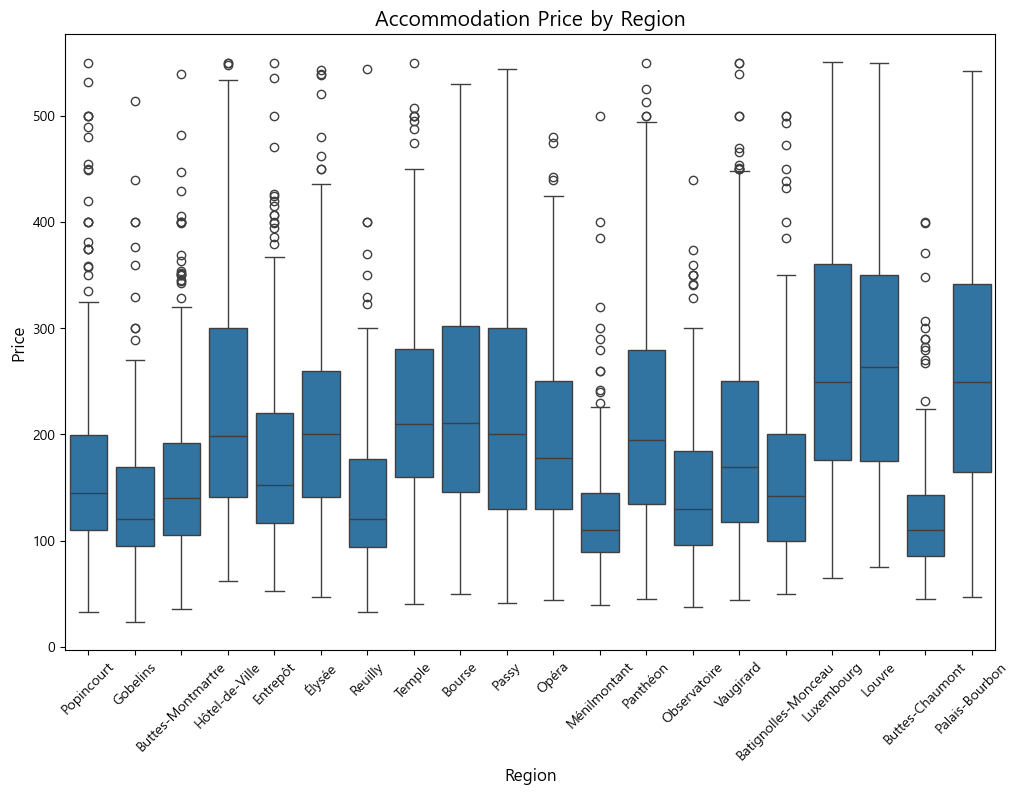

In [18]:
# 숙소_가격과 숙소_지역에 따른 분포
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_guest_prefer, x='숙소_지역', y='숙소_가격')
plt.title('Accommodation Price by Region', fontsize=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Passy 지역에 가장 큰 이상치 존재(<- 수용_인원수, 숙소_가격 이상치 제거 전 결과임)

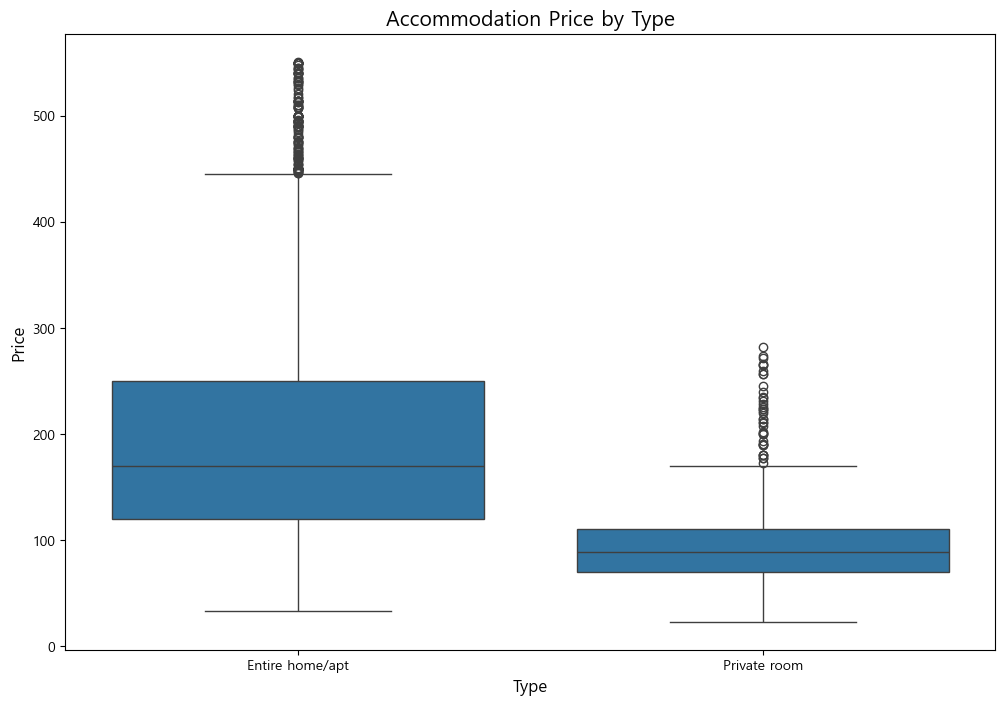

In [19]:
# 숙소_가격과 숙소_유형에 따른 분포
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_guest_prefer, x='숙소_유형', y='숙소_가격')
plt.title('Accommodation Price by Type', fontsize=15)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()


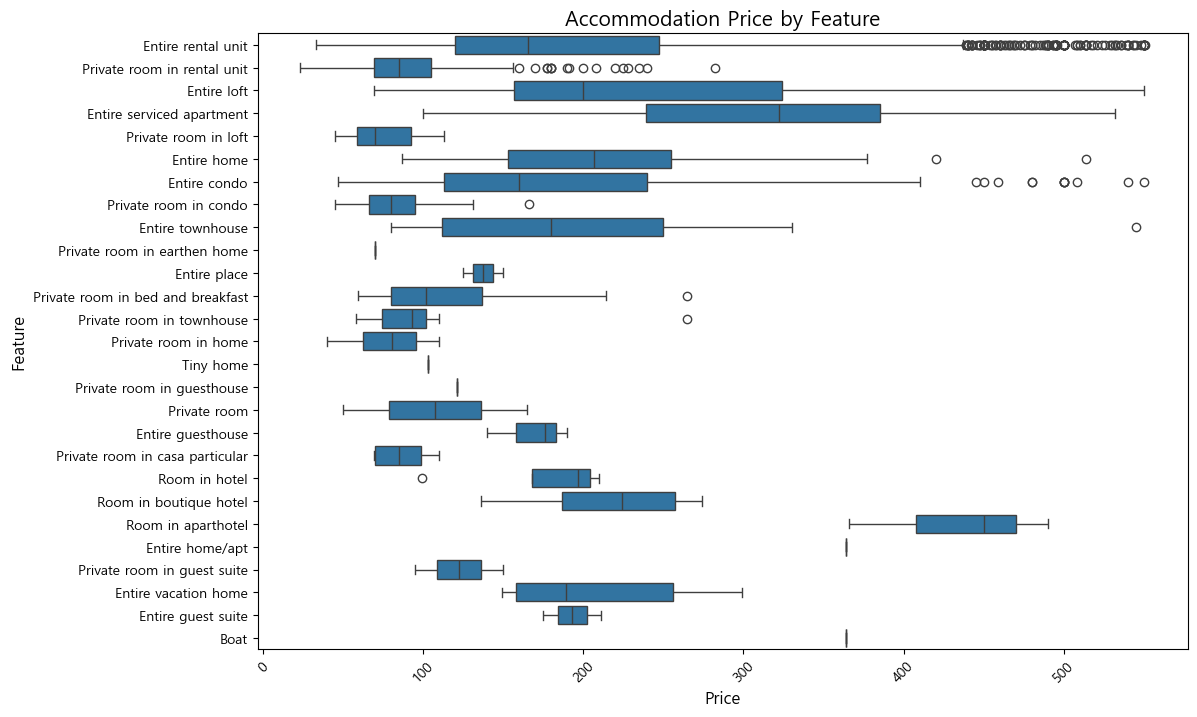

In [20]:
# 숙소_가격과 숙소_특징에 따른 분포
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_guest_prefer, x='숙소_가격', y='숙소_특징')
plt.title('Accommodation Price by Feature', fontsize=15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Entire rental unit에 이상치 값이 많음

In [21]:
df_guest_prefer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4322 entries, 27 to 78309
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   숙소_수         4322 non-null   float64
 1   숙소_지역        4322 non-null   object 
 2   숙소_유형        4322 non-null   object 
 3   수용_인원수       4322 non-null   int64  
 4   욕실수          4322 non-null   float64
 5   침실수          4322 non-null   float64
 6   침대수          4322 non-null   float64
 7   숙소_가격        4322 non-null   float64
 8   최소_숙박일       4322 non-null   int64  
 9   최대_숙박일       4322 non-null   int64  
 10  리뷰수          4322 non-null   int64  
 11  30일_리뷰수      4322 non-null   int64  
 12  리뷰점수         4322 non-null   float64
 13  숙소_정확성_리뷰점수  4322 non-null   float64
 14  숙소_청결도_리뷰점수  4322 non-null   float64
 15  숙소_체크인_리뷰점수  4322 non-null   float64
 16  숙소_소통_리뷰점수   4322 non-null   float64
 17  숙소_위치_리뷰점수   4322 non-null   float64
 18  숙소_가격_리뷰점수   4322 non-null   float64
 19  평균_리뷰수   

회귀분석 모델
 - 종속변수 : 리뷰점수

In [22]:
import statsmodels.api as sm

# 독립변수와 종속변수 설정
X = df_guest_prefer.drop(['숙소_지역','숙소_유형','숙소_특징'], axis=1)
y = df_guest_prefer['리뷰점수']

# 상수항 추가
X = sm.add_constant(X)

# 회귀모델 적합
model = sm.OLS(y, X).fit()

# 회귀분석 결과 출력
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   리뷰점수   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.090e+26
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:51:28   Log-Likelihood:             1.2743e+05
No. Observations:                4322   AIC:                        -2.548e+05
Df Residuals:                    4302   BIC:                        -2.547e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.066e-14    9.6e-14     -0.111      

### p-value가 0.05 이상인 독립변수 제외

In [23]:
# p-value가 0.05 이상인 독립변수 제외
selected_features = model.pvalues[model.pvalues < 0.05].index
X_selected = X[selected_features]

# 새로운 회귀모델 적합
new_model = sm.OLS(y, X_selected).fit()

# 새로운 회귀분석 결과 출력
print(new_model.summary())


                                 OLS Regression Results                                
Dep. Variable:                   리뷰점수   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.187e+32
Date:                Sat, 08 Jun 2024   Prob (F-statistic):                        0.00
Time:                        14:51:28   Log-Likelihood:                      1.3194e+05
No. Observations:                4322   AIC:                                 -2.639e+05
Df Residuals:                    4317   BIC:                                 -2.638e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

R-squared (uncentered): 1.000 <br>
뭔가 잘못 된 것 같음...
 - 종속변수를 게스트 선호 리뷰점수가 아닌 전체 데이터의 리뷰점수로 놓고 해봐야겠음.
 

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['슈퍼호스트_라벨링'] = label_encoder.fit_transform(df['슈퍼호스트'])

In [25]:
df.head(2)

,숙소_id,호스트_id,슈퍼호스트,숙소_수,숙소_지역,숙소_유형,수용_인원수,욕실수,침실수,침대수,...,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,url,숙소_특징,12개월_리뷰수,예약가능여부,마지막_리뷰,슈퍼호스트_라벨링
1,165409,788732,t,1.0,Temple,Entire home/apt,2,1.0,0.0,1.0,...,4.89,4.95,4.74,0.69,https://www.airbnb.com/rooms/165409,Entire rental unit,14,t,2023-10-21,1
2,5396,7903,f,3.0,Hôtel-de-Ville,Entire home/apt,2,1.0,0.0,1.0,...,4.84,4.96,4.58,2.19,https://www.airbnb.com/rooms/5396,Entire rental unit,61,t,2024-03-14,0


In [26]:
df_temp = df.drop(columns=['숙소_id', '호스트_id', 'url', '편의시설','예약가능여부','마지막_리뷰',
                            '슈퍼호스트','숙소_지역', '숙소_유형','숙소_특징'])

In [27]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28842 entries, 1 to 83158
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   숙소_수         28842 non-null  float64
 1   수용_인원수       28842 non-null  int64  
 2   욕실수          28842 non-null  float64
 3   침실수          28842 non-null  float64
 4   침대수          28842 non-null  float64
 5   숙소_가격        28842 non-null  float64
 6   최소_숙박일       28842 non-null  int64  
 7   최대_숙박일       28842 non-null  int64  
 8   리뷰수          28842 non-null  int64  
 9   30일_리뷰수      28842 non-null  int64  
 10  리뷰점수         28842 non-null  float64
 11  숙소_정확성_리뷰점수  28842 non-null  float64
 12  숙소_청결도_리뷰점수  28842 non-null  float64
 13  숙소_체크인_리뷰점수  28842 non-null  float64
 14  숙소_소통_리뷰점수   28842 non-null  float64
 15  숙소_위치_리뷰점수   28842 non-null  float64
 16  숙소_가격_리뷰점수   28842 non-null  float64
 17  평균_리뷰수       28842 non-null  float64
 18  12개월_리뷰수     28842 non-null  int64  
 19  슈퍼호스트_라벨링

In [28]:
# import statsmodels.api as sm

# # 독립변수와 종속변수 설정
# X = df_temp[(df_temp['리뷰점수'] >= 4.9) & (df_temp['리뷰수'] >= 5) & (df_temp['슈퍼호스트_라벨링'] == 1)]
# y = df_temp['리뷰점수']

# # 상수항 추가
# X = sm.add_constant(X)

# # 회귀모델 적합
# model = sm.OLS(y, X).fit()

# # 회귀분석 결과 출력
# print(model.summary())



서로 index 값이 다르므로 회귀 분석 못함.

기존 데이터에 새로운 컬럼 삽입(좋은숙소) -> t,f 범주형<br>
-> 정규화<br>
-> 회귀분석<br>
-> p-value 0.05이상 제외 다시 분석<br>
-> 그리고 예측 모델 돌려보기

In [29]:
df_temp = df.copy()
df_temp.head(5)

,숙소_id,호스트_id,슈퍼호스트,숙소_수,숙소_지역,숙소_유형,수용_인원수,욕실수,침실수,침대수,...,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,url,숙소_특징,12개월_리뷰수,예약가능여부,마지막_리뷰,슈퍼호스트_라벨링
1,165409,788732,t,1.0,Temple,Entire home/apt,2,1.0,0.0,1.0,...,4.89,4.95,4.74,0.69,https://www.airbnb.com/rooms/165409,Entire rental unit,14,t,2023-10-21,1
2,5396,7903,f,3.0,Hôtel-de-Ville,Entire home/apt,2,1.0,0.0,1.0,...,4.84,4.96,4.58,2.19,https://www.airbnb.com/rooms/5396,Entire rental unit,61,t,2024-03-14,0
3,166370,793032,f,3.0,Entrepôt,Entire home/apt,4,1.0,1.0,1.0,...,4.79,4.65,4.48,0.51,https://www.airbnb.com/rooms/166370,Entire rental unit,1,t,2023-06-21,0
6,7397,2626,t,9.0,Hôtel-de-Ville,Entire home/apt,4,1.0,2.0,2.0,...,4.88,4.93,4.73,2.21,https://www.airbnb.com/rooms/7397,Entire rental unit,19,t,2024-02-23,1
8,41106,177387,t,2.0,Hôtel-de-Ville,Entire home/apt,4,1.0,1.0,2.0,...,4.94,4.96,4.69,0.67,https://www.airbnb.com/rooms/41106,Entire rental unit,13,t,2024-01-02,1


In [30]:
df_temp['좋은숙소'] = ((df_temp['리뷰점수'] >= 4.9) & (df_temp['리뷰수'] >= 5) & (df_temp['슈퍼호스트'] == 't')).astype(int)

In [31]:
df_temp.head(3)

,숙소_id,호스트_id,슈퍼호스트,숙소_수,숙소_지역,숙소_유형,수용_인원수,욕실수,침실수,침대수,...,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,url,숙소_특징,12개월_리뷰수,예약가능여부,마지막_리뷰,슈퍼호스트_라벨링,좋은숙소
1,165409,788732,t,1.0,Temple,Entire home/apt,2,1.0,0.0,1.0,...,4.95,4.74,0.69,https://www.airbnb.com/rooms/165409,Entire rental unit,14,t,2023-10-21,1,0
2,5396,7903,f,3.0,Hôtel-de-Ville,Entire home/apt,2,1.0,0.0,1.0,...,4.96,4.58,2.19,https://www.airbnb.com/rooms/5396,Entire rental unit,61,t,2024-03-14,0,0
3,166370,793032,f,3.0,Entrepôt,Entire home/apt,4,1.0,1.0,1.0,...,4.65,4.48,0.51,https://www.airbnb.com/rooms/166370,Entire rental unit,1,t,2023-06-21,0,0


In [32]:
df_temp.drop(columns=['숙소_id', '호스트_id', 'url', '편의시설','예약가능여부','마지막_리뷰','슈퍼호스트',
                      '숙소_지역', '숙소_유형','숙소_특징'], axis=1, inplace=True)
df_temp.head(3)

,숙소_수,수용_인원수,욕실수,침실수,침대수,숙소_가격,최소_숙박일,최대_숙박일,리뷰수,30일_리뷰수,...,숙소_정확성_리뷰점수,숙소_청결도_리뷰점수,숙소_체크인_리뷰점수,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,12개월_리뷰수,슈퍼호스트_라벨링,좋은숙소
1,1.0,2,1.0,0.0,1.0,140.0,3,365,106,0,...,4.72,4.59,4.87,4.89,4.95,4.74,0.69,14,1,0
2,3.0,2,1.0,0.0,1.0,107.0,1,1125,393,5,...,4.63,4.57,4.81,4.84,4.96,4.58,2.19,61,0,0
3,3.0,4,1.0,1.0,1.0,200.0,2,120,78,0,...,4.74,4.37,4.82,4.79,4.65,4.48,0.51,1,0,0


In [33]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28842 entries, 1 to 83158
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   숙소_수         28842 non-null  float64
 1   수용_인원수       28842 non-null  int64  
 2   욕실수          28842 non-null  float64
 3   침실수          28842 non-null  float64
 4   침대수          28842 non-null  float64
 5   숙소_가격        28842 non-null  float64
 6   최소_숙박일       28842 non-null  int64  
 7   최대_숙박일       28842 non-null  int64  
 8   리뷰수          28842 non-null  int64  
 9   30일_리뷰수      28842 non-null  int64  
 10  리뷰점수         28842 non-null  float64
 11  숙소_정확성_리뷰점수  28842 non-null  float64
 12  숙소_청결도_리뷰점수  28842 non-null  float64
 13  숙소_체크인_리뷰점수  28842 non-null  float64
 14  숙소_소통_리뷰점수   28842 non-null  float64
 15  숙소_위치_리뷰점수   28842 non-null  float64
 16  숙소_가격_리뷰점수   28842 non-null  float64
 17  평균_리뷰수       28842 non-null  float64
 18  12개월_리뷰수     28842 non-null  int64  
 19  슈퍼호스트_라벨링

MinMaxScaler 적용 후 로지스틱 회귀 돌려본 결과

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 정규화 대상 열 추출 (슈퍼호스트_라벨링, 좋은숙소 제외)
columns_to_normalize = df_temp.columns.difference(['슈퍼호스트_라벨링', '좋은숙소'])

# MinMaxScaler를 사용한 정규화
scaler = MinMaxScaler()
df_temp[columns_to_normalize] = scaler.fit_transform(df_temp[columns_to_normalize])

# 독립변수(X)와 종속변수(y) 설정
X = df_temp.drop(columns=['좋은숙소'])
y = df_temp['좋은숙소']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 생성 및 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'모델 정확도: {accuracy:.2f}')

모델 정확도: 0.96


In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# 혼동행렬(오차행렬)
confusion_matrix(y_test,y_pred)
print(confusion_matrix)

acc = accuracy_score(y_test,y_pred)
precision = precision_score (y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test,y_pred)

print('-'*20)
print('정확도:{0:.3f}, 정밀도:{1:.3f}, 재현율:{2:.3f}, f1:{3:.3f}'. format(acc,precision, recall,f1))
print('-'*20)
print('ROC_AUC: {0:.3f}'.format(roc_auc))

<function confusion_matrix at 0x000002E1BFDBFBA0>
--------------------
정확도:0.956, 정밀도:0.854, 재현율:0.864, f1:0.859
--------------------
ROC_AUC: 0.918


이상치 제거 전 <br>
정확도:0.960, 정밀도:0.856, 재현율:0.895, f1:0.875<br>
ROC_AUC: 0.934

이상치 제거 후 결과값 : 

정확도:0.956, 정밀도:0.854, 재현율:0.864, f1:0.859<br>
ROC_AUC: 0.918

StandardScaler 적용 후 로지스틱 회귀 돌려본 결과

In [36]:
# # 필요한 라이브러리 임포트
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# # 데이터프레임 복사 및 정규화 대상 열 추출
# df_copy = df_temp.drop(['슈퍼호스트_라벨링', '좋은숙소'], axis=1)

# # StandardScaler를 사용한 정규화
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)

# # 독립변수(X)와 종속변수(y) 설정
# X = df_scaled
# y = df_temp['좋은숙소']

# # 학습 데이터와 테스트 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 로지스틱 회귀 모델 생성 및 학습
# model = LogisticRegression()
# model.fit(X_train, y_train)

# # 예측
# y_pred = model.predict(X_test)

# # 정확도 평가
# accuracy = accuracy_score(y_test, y_pred)
# print(f'모델의 정확도: {accuracy:.2f}')

# # 모델의 정확도: 0.87

In [37]:
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# # 혼동행렬(오차행렬)
# confusion_matrix(y_test,y_pred)
# print(confusion_matrix)

# acc = accuracy_score(y_test,y_pred)
# precision = precision_score (y_test,y_pred)
# recall = recall_score(y_test,y_pred)
# f1 = f1_score(y_test,y_pred)
# roc_auc = roc_auc_score(y_test,y_pred)

# print('-'*20)
# print('정확도:{0:.3f}, 정밀도:{1:.3f}, 재현율:{2:.3f}, f1:{3:.3f}'. format(acc,precision, recall,f1))
# print('-'*20)
# print('ROC_AUC: {0:.3f}'.format(roc_auc))

이상치 제거 전<br>
정확도:0.872, 정밀도:0.670, 재현율:0.350, f1:0.459<br>
ROC_AUC: 0.659

이상치 제거(수용_인원수, 숙소_가격) 후 결과 : <br>

정확도:0.871, 정밀도:0.667, 재현율:0.336, f1:0.446<br>
ROC_AUC: 0.652

MinMaxScaler 로 만든 모델이 더 뛰어남!!!

In [38]:
import statsmodels.api as sm

# MinMaxScaler를 사용한 정규화
scaler = MinMaxScaler()
df_temp[columns_to_normalize] = scaler.fit_transform(df_temp[columns_to_normalize])

# 독립변수(X)와 종속변수(y) 설정
X = df_temp.drop(columns=['좋은숙소'])
y = df_temp['좋은숙소']

# 상수항 추가
X = sm.add_constant(X)

# 회귀모델 적합
model = sm.OLS(y, X).fit()

# 회귀분석 결과 출력
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   좋은숙소   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     970.1
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:51:29   Log-Likelihood:                -3788.3
No. Observations:               28842   AIC:                             7619.
Df Residuals:                   28821   BIC:                             7792.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4617      0.027    -16.889      

p-value 0.05 이상 값 제거 후 

In [39]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

# 데이터 정규화
scaler = MinMaxScaler()
df_temp[columns_to_normalize] = scaler.fit_transform(df_temp[columns_to_normalize])

# p-value가 0.05보다 높은 변수 제외
X = df_temp.drop(columns=['좋은숙소', '수용_인원수', '침실수', '침대수', '숙소_가격','숙소_체크인_리뷰점수'])
y = df_temp['좋은숙소']

# 상수항 추가
X = sm.add_constant(X)

# 회귀모델 적합
model = sm.OLS(y, X).fit()

# 회귀분석 결과 출력
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   좋은숙소   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     1276.
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:51:29   Log-Likelihood:                -3867.8
No. Observations:               28842   AIC:                             7768.
Df Residuals:                   28826   BIC:                             7900.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5265      0.027    -19.679      

2024/06/03 지금 배운 의사결정나무 모델에 minmaxscaler로 만든 모델 적용

In [40]:
from sklearn.tree import DecisionTreeClassifier

# 결정트리 분류 분석: 모델 생성
dt = DecisionTreeClassifier(random_state=42)

In [41]:
# 모델 훈련
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [42]:
# 평가 데이터(x_test) 에측 수행 >> y_pred 구하기

y_pred = dt.predict(X_test)

In [43]:
# 결과분석
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print('의사결정나무 예측 정확도:{0:.3f}'.format(acc))

의사결정나무 예측 정확도:1.000


??? 뭘 잘못생각했나? 
 -> 왜 1.000 이지...


수용_인원수 와 숙소_가격 이상치 제거 후 결과값들이 떨어짐. -> 오히려 성능 저하가 발생함.
 - 그런데 의사결정나무 예측은 그대로 100%임...

공통요인 분석으로 나온 주요인으로 의사결정나무 진행해보기
 - 이렇게 하면 게스트 선호 기준이 좋은 숙소인 점이라는 것을 뒷받침할 수 있을 것으로 보임.

공통요인 분석

In [44]:
!pip install factor-analyzer

Defaulting to user installation because normal site-packages is not writeable


In [45]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28842 entries, 1 to 83158
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   숙소_수         28842 non-null  float64
 1   수용_인원수       28842 non-null  float64
 2   욕실수          28842 non-null  float64
 3   침실수          28842 non-null  float64
 4   침대수          28842 non-null  float64
 5   숙소_가격        28842 non-null  float64
 6   최소_숙박일       28842 non-null  float64
 7   최대_숙박일       28842 non-null  float64
 8   리뷰수          28842 non-null  float64
 9   30일_리뷰수      28842 non-null  float64
 10  리뷰점수         28842 non-null  float64
 11  숙소_정확성_리뷰점수  28842 non-null  float64
 12  숙소_청결도_리뷰점수  28842 non-null  float64
 13  숙소_체크인_리뷰점수  28842 non-null  float64
 14  숙소_소통_리뷰점수   28842 non-null  float64
 15  숙소_위치_리뷰점수   28842 non-null  float64
 16  숙소_가격_리뷰점수   28842 non-null  float64
 17  평균_리뷰수       28842 non-null  float64
 18  12개월_리뷰수     28842 non-null  float64
 19  슈퍼호스트_라벨링

In [46]:
df_temp['좋은숙소'].value_counts()

좋은숙소
0    24520
1     4322
Name: count, dtype: int64

In [47]:
df_temp.head()

,숙소_수,수용_인원수,욕실수,침실수,침대수,숙소_가격,최소_숙박일,최대_숙박일,리뷰수,30일_리뷰수,...,숙소_정확성_리뷰점수,숙소_청결도_리뷰점수,숙소_체크인_리뷰점수,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,12개월_리뷰수,슈퍼호스트_라벨링,좋은숙소
1,0.000000,0.166667,0.125,0.000000,0.071429,0.240296,0.005495,0.323843,0.035493,0.000000,...,0.906667,0.892105,0.956667,0.966154,0.981273,0.927778,0.017809,0.015777,1,0
2,0.000666,0.166667,0.125,0.000000,0.071429,0.179298,0.000000,1.000000,0.134390,0.076923,...,0.876667,0.886842,0.936667,0.950769,0.985019,0.883333,0.058284,0.072816,0,0
3,0.000666,0.500000,0.125,0.030303,0.071429,0.351201,0.002747,0.105872,0.025844,0.000000,...,0.913333,0.834211,0.940000,0.935385,0.868914,0.855556,0.012952,0.000000,0,0
6,0.002666,0.500000,0.125,0.060606,0.142857,0.229205,0.024725,0.114769,0.118884,0.030769,...,0.933333,0.855263,0.970000,0.963077,0.973783,0.925000,0.058824,0.021845,1,0
8,0.000333,0.500000,0.125,0.030303,0.142857,0.471349,0.010989,0.648577,0.037216,0.000000,...,0.936667,0.907895,0.900000,0.981538,0.985019,0.913889,0.017269,0.014563,1,0


In [48]:
# 필요한 라이브러리 불러오기
import pandas as pd
from factor_analyzer import FactorAnalyzer

In [49]:
# 필요한 라이브러리를 임포트합니다.
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

# FactorAnalyzer 초기화
fa = FactorAnalyzer(rotation=None, n_factors=df_temp.shape[1], method='principal')
fa.fit(df_temp)

# 고유값(Eigenvalues) 확인
ev, v = fa.get_eigenvalues()
print(ev)

[5.13210189 3.05936291 2.79056712 1.33439291 1.16068336 0.95417812
 0.87440446 0.78806071 0.71317109 0.6834115  0.60940022 0.48956892
 0.4721244  0.37107906 0.31859399 0.30491083 0.24706423 0.22449489
 0.18927687 0.17304291 0.11010962]


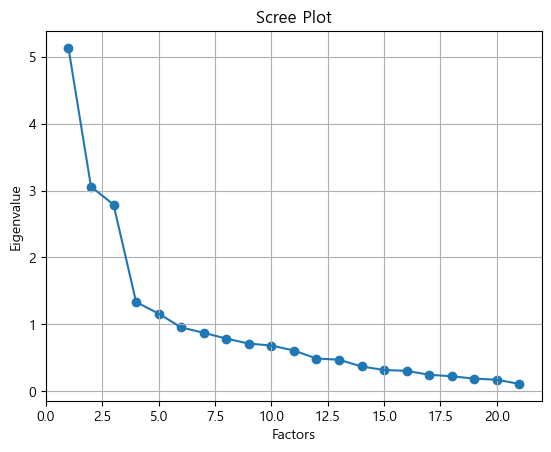

In [50]:
# 스크리 플롯으로 요인 수 결정
plt.scatter(range(1, df_temp.shape[1]+1), ev)
plt.plot(range(1, df_temp.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [51]:
# 요인 수 결정 (예: 고유값이 1 이상인 요인 수)
n_factors = sum(ev > 1)

# 요인 분석 재실행, 이번에는 요인 수 지정
fa = FactorAnalyzer(rotation="varimax", n_factors=n_factors)
fa.fit(df_temp)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [52]:
# 요인 부하량 확인
loadings = fa.loadings_
print(pd.DataFrame(loadings, index=df_temp.columns))

                    0         1         2         3         4
숙소_수        -0.123547  0.048958 -0.031818 -0.076413 -0.287431
수용_인원수      -0.073475  0.873215  0.062468 -0.043700 -0.011888
욕실수          0.060706  0.514240  0.006433  0.009665 -0.101311
침실수          0.051382  0.703273 -0.040969 -0.009038  0.016491
침대수         -0.056890  0.800238  0.039169 -0.013327  0.019007
숙소_가격        0.177092  0.634172 -0.076608  0.090860 -0.168398
최소_숙박일      -0.019587 -0.067163 -0.125121  0.025347 -0.044652
최대_숙박일      -0.067700  0.046933  0.046151 -0.022686 -0.208175
리뷰수          0.016962 -0.013125  0.596179  0.095216 -0.035990
30일_리뷰수      0.018766 -0.057667  0.698711 -0.037598 -0.033857
리뷰점수         0.932051  0.045638 -0.016080  0.142333  0.162445
숙소_정확성_리뷰점수  0.873868  0.015957 -0.005769  0.097207  0.149285
숙소_청결도_리뷰점수  0.758772  0.039189  0.061734  0.160680 -0.005423
숙소_체크인_리뷰점수  0.647031  0.009504  0.038435  0.045420  0.419479
숙소_소통_리뷰점수   0.712042  0.013195  0.035409  0.047177  0.492969
숙소_위치_리뷰

0.6 이상 값들 <br>
0 : 리뷰점수 / 정확성 / 청결도 / 체크인 / 소통 / 가격 <br>
1 : 수용_인원수 / 침실수 / 침대수 / 숙소_가격 <br>
2 : 리뷰수 / 30일_리뷰수 / 평균_리뷰수 / 12개월_리뷰수 <br>
3 : 슈퍼호스트_라벨링 / 좋은숙소 <br>
4 : 없음

In [53]:
# 요인 점수 계산
factor_scores = fa.transform(df_temp)
print(factor_scores)

[[-0.2269161  -0.80776065 -0.29613187  1.3180203   0.42840061]
 [-0.11853524 -0.92218294  2.18159874 -0.7859812  -0.42053191]
 [-0.48218931  0.15646666 -0.74545206 -0.62696413  0.31527312]
 ...
 [ 1.23906296 -1.06899924  0.44437593 -1.06186331 -0.16245316]
 [ 1.00512623  0.39202625  0.19861986 -1.07750085  0.39436487]
 [-1.48820183  1.48717835  0.25567449 -0.77699488  0.96554962]]


선형회귀 분석

In [54]:
import statsmodels.api as sm

# 상수항 추가
X = sm.add_constant(factor_scores)  # 독립 변수
y = df_temp['좋은숙소']  # 종속 변수

# 회귀모형 적합
model = sm.OLS(y, X).fit()

# 회귀분석 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   좋은숙소   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     5038.
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:51:37   Log-Likelihood:                -2157.3
No. Observations:               28842   AIC:                             4327.
Df Residuals:                   28836   BIC:                             4376.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1499      0.002     97.584      0.0

로지스틱 회귀분석

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(factor_scores, df_temp['좋은숙소'], test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 생성 및 학습
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# 예측 및 평가
y_pred = log_reg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[7317   15]
 [  11 1310]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7332
           1       0.99      0.99      0.99      1321

    accuracy                           1.00      8653
   macro avg       0.99      0.99      0.99      8653
weighted avg       1.00      1.00      1.00      8653



결과 분석 : <br>
True Negative (TN, 진짜 음성): 모델이 "좋은 숙소"가 아니라고 정확하게 예측한 경우의 수 (7317) <br>
False Positive (FP, 거짓 양성): 모델이 "좋은 숙소"가 아닌데 "좋은 숙소"라고 잘못 예측한 경우의 수 (15) <br>
False Negative (FN, 거짓 음성): 모델이 "좋은 숙소"인데 "좋은 숙소"가 아니라고 잘못 예측한 경우의 수 (11) <br>
True Positive (TP, 진짜 양성): 모델이 "좋은 숙소"라고 정확하게 예측한 경우의 수 (1310) <br>

주요 성능 지표<br>
정확도(Accuracy): 전체 데이터 중에서 모델이 정확하게 예측한 데이터의 비율. (7317 + 1310) / 8653 = 약 1.00, 즉 약 100%<br>
정밀도(Precision): "좋은 숙소"라고 예측된 경우 중 실제로 "좋은 숙소"인 경우의 비율. 1310 / (1310 + 15) = 약 0.99, 즉 약 99%<br>
재현율(Recall): 실제 "좋은 숙소" 중에서 모델이 "좋은 숙소"라고 정확하게 예측한 경우의 비율. 1310 / (1310 + 11) = 약 0.99, 즉 약 99%<br>
F1 점수(F1 Score): 정밀도와 재현율의 조화 평균. 2 * (0.99 * 0.99) / (0.99 + 0.99) = 약 0.99, 즉 약 99%<br>

의사결정트리 분석

In [56]:
from sklearn.tree import DecisionTreeClassifier

# 결정트리 분류 분석: 모델 생성
dt = DecisionTreeClassifier(random_state=42)

In [57]:
# 모델 훈련
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [58]:
# 평가 데이터(x_test) 에측 수행 >> y_pred 구하기

y_pred = dt.predict(X_test)

In [59]:
# 결과분석
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print('의사결정나무 예측 정확도:{0:.3f}'.format(acc))

의사결정나무 예측 정확도:0.993


전체적인 결과값이 높게 나왔으므로 좋은숙소(게스트 선호)를 채택해도 될 것으로 사료됨.

과적합 확인

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# 로지스틱 회귀 모델 교차 검증
log_reg = LogisticRegression()
log_reg_scores = cross_val_score(log_reg, factor_scores, df_temp['좋은숙소'], cv=5)

print("로지스틱 회귀 모델 교차 검증 점수:", log_reg_scores)
print("로지스틱 회귀 모델 평균 교차 검증 점수:", log_reg_scores.mean())

# 결정 트리 모델 교차 검증
dt = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt, factor_scores, df_temp['좋은숙소'], cv=5)

print("결정 트리 모델 교차 검증 점수:", dt_scores)
print("결정 트리 모델 평균 교차 검증 점수:", dt_scores.mean())

로지스틱 회귀 모델 교차 검증 점수: [0.9982666  0.99809326 0.99895978 0.99791956 0.9918516 ]
로지스틱 회귀 모델 평균 교차 검증 점수: 0.9970181567318172
결정 트리 모델 교차 검증 점수: [0.98977292 0.99185301 0.99393204 0.995319   0.98474341]
결정 트리 모델 평균 교차 검증 점수: 0.9911240767707454


결과 해석 : 
 - 로지스틱 회귀 모델 : 교차 검증 점수 높고, 일관성이 있음 => 모델이 데이터에 잘 맞음
 - 검증 점수 : 0.997 -> 일반화된 성능이 매우 높음
 - 모든 폴드에 걸친 점수 차이가 크지 않아 과적합이 발생하지 않은 것으로 사료됨.
 
 - 결정 트리 모델 : 교차 검증 점수 높고, 일관성이 있음 => 모델이 데이터에 잘 맞음
 - 검증 점수 : 0.991 -> 일반화된 성능이 매우 높음
 - 과적합이 발생하지 않은 것으로 사료됨.
<br>
종합 해석 : 로지스틱 회귀 모델이 결정 트리 모델보다 조금 더 안정적인 성능을 보이는 것으로 사료됨.

혹시 몰라서 PCA 분석으로 진행해봄

In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 독립변인과 종속변인 설정
x = df_temp.drop(columns=['리뷰점수']).values  # 독립변인들의 값만 추출
y = df_temp['리뷰점수'].values  # 종속변인 추출

# 결측값 처리
imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)

# 표준화
scaler = StandardScaler()
x_standardized = scaler.fit_transform(x_imputed)

# PCA 적용
pca = PCA(n_components=7)  # 주성분 개수
principal_components = pca.fit_transform(x_standardized)

# 결과를 데이터프레임으로 변환
df_pca = pd.DataFrame(data=principal_components, columns=['pc1','pc2','pc3','pc4',
                                                          'pc5','pc6','pc7'])
df_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7
0,-0.418828,1.427802,-0.800705,0.659611,0.195268,-0.057533,-0.541104
1,0.236224,3.646042,3.951579,-1.131945,1.509122,0.290480,-1.877093
2,1.119267,-0.393633,-0.794611,-0.270118,-0.827598,0.143178,-0.308195
3,-0.884713,0.539109,2.543962,0.371164,-0.040128,1.441257,-0.774291
4,-0.603084,-0.738389,0.225091,0.717240,0.667305,-0.024314,-1.099241
...,...,...,...,...,...,...,...
28837,-1.665633,1.093862,-0.296479,-1.734532,-0.226622,-0.153717,0.827881
28838,-1.393387,2.400627,1.370365,-1.938922,-0.747203,-0.102385,1.082216
28839,-1.525059,2.191919,-0.006875,-1.915497,0.868031,-0.626798,-0.138777
28840,-1.736578,-0.152461,0.310140,-1.753043,-0.501951,0.112631,0.506948


In [61]:
pca.explained_variance_ratio_

array([0.21478866, 0.15296462, 0.13890343, 0.06620234, 0.0579604 ,
       0.04769166, 0.04368848])

In [62]:
explained_variance_ratio = pca.explained_variance_ratio_

# 설명된 분산의 합계
cumulative_variance = 0.0
# 필요한 주성분의 개수
num_components = 0

# 설명된 분산의 누적 합이 0.7을 넘을 때까지 반복
for variance in explained_variance_ratio:
    cumulative_variance += variance
    num_components += 1
    if cumulative_variance > 0.7:
        break

print(f"설명된 분산이 0.7을 넘기 위해 필요한 주성분의 개수는 {num_components}개입니다.")

설명된 분산이 0.7을 넘기 위해 필요한 주성분의 개수는 7개입니다.


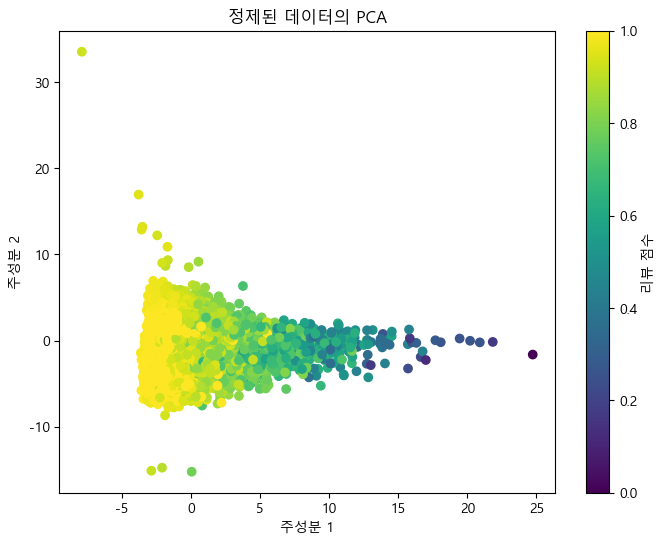

In [63]:
# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['pc1'], df_pca['pc2'], c=y, cmap='viridis')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.title('정제된 데이터의 PCA')
plt.colorbar(label='리뷰 점수')
plt.show()

선형회귀 분석

In [64]:
# df_temp 인덱스 재설정
df_temp_reset = df_temp.reset_index(drop=True)

# 종속변수 재설정
y = df_temp_reset['좋은숙소'].values

# 상수항 추가하고 회귀모형 적합
X = sm.add_constant(df_pca)  # 독립 변수
model = sm.OLS(y, X).fit()

# 회귀분석 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                 1.763e+04
Date:                Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:51:38   Log-Likelihood:                 12786.
No. Observations:               28842   AIC:                        -2.556e+04
Df Residuals:                   28834   BIC:                        -2.549e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1499      0.001    163.823      0.0

로지스틱 회귀 분석

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(df_pca, df_temp_reset['좋은숙소'], test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 생성 및 학습
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# 예측 및 평가
y_pred = log_reg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[7332    0]
 [   0 1321]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7332
           1       1.00      1.00      1.00      1321

    accuracy                           1.00      8653
   macro avg       1.00      1.00      1.00      8653
weighted avg       1.00      1.00      1.00      8653



In [66]:
from sklearn.tree import DecisionTreeClassifier

# 결정트리 분류 분석: 모델 생성
dt = DecisionTreeClassifier(random_state=42)

# 모델 훈련
dt.fit(X_train,y_train)

# 평가 데이터(x_test) 에측 수행 >> y_pred 구하기
y_pred = dt.predict(X_test)

# 결과분석
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print('의사결정나무 예측 정확도:{0:.3f}'.format(acc))

의사결정나무 예측 정확도:0.999


과적합 확인

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# 로지스틱 회귀 모델 교차 검증
log_reg = LogisticRegression()
log_reg_scores = cross_val_score(log_reg, df_pca, df_temp['좋은숙소'], cv=5)

print("로지스틱 회귀 모델 교차 검증 점수:", log_reg_scores)
print("로지스틱 회귀 모델 평균 교차 검증 점수:", log_reg_scores.mean())

# 결정 트리 모델 교차 검증
dt = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(dt, df_pca, df_temp['좋은숙소'], cv=5)

print("결정 트리 모델 교차 검증 점수:", cv_scores)
print("결정 트리 모델 평균 교차 검증 점수:", cv_scores.mean())


로지스틱 회귀 모델 교차 검증 점수: [1. 1. 1. 1. 1.]
로지스틱 회귀 모델 평균 교차 검증 점수: 1.0
결정 트리 모델 교차 검증 점수: [0.99965332 0.99878662 0.99947989 0.99947989 0.99739945]
결정 트리 모델 평균 교차 검증 점수: 0.9989598321796949


결과 해석 : 
- 로지스틱 회귀 모델 : [1. 1. 1. 1. 1.] -> 과적합 의심

- 결정 트리 모델 : 로지스틱 모델에 비해서는 더 신뢰할 수 있는 모델로 보여짐.
- 여전히 과적합의 가능성을 배제할 수는 없음.

공통요인 분석 결과를 채택하는 것이 더 논리적인 방향이라고 사료됨.